In [3]:
import pandas as pd
from tqdm import tqdm
from copy import copy
import numpy as np
import json
import warnings
import xlrd
from operator import add
warnings.filterwarnings('ignore')

for output_matrix , the rows represents the sectors producing goods (each country has 26 sectors), while the columns represents the countries demanding those products. the above mentioned code calculate the output fraction of each sector of each country, do you think we can calculate the demand fraction

## Types of Final Demand Fractions

### 1. Direct Final Demand Fraction
The **direct final demand fraction** represents the proportion of total final demand allocated directly to each sector. This fraction reflects the immediate purchases made by consumers, firms, and governments in the final demand category. Mathematically, if $( f_i )$ is the direct final demand for sector \( i \), and \( F \) is the total final demand across all sectors, the direct final demand fraction is given by:

$
D_i = \frac{f_i}{F}
$

where $( D_i )$ represents the share of sector \( i \) in total final demand.

### 2. Total (Indirect-Adjusted) Final Demand Fraction (Leontief-Adjusted Final Demand)
The **total final demand fraction**, adjusted using the **Leontief inverse**, accounts for both **direct and indirect** demand linkages across sectors. Since production in each sector relies on intermediate inputs from other sectors, final demand for one sector indirectly drives demand for upstream sectors. This adjusted fraction is derived using the **Leontief inverse matrix** $( (I - A)^{-1} )$, where \( A \) represents the technical coefficients matrix. The total final demand fraction for sector \( i \) is given by:

$
T_i = \frac{\sum_{j} L_{ij} f_j}{\sum_{i} \sum_{j} L_{ij} f_j}
$

where:
- $( L_{ij} )$ is the Leontief inverse matrix element, capturing total input requirements,
- $( f_j )$ is the direct final demand for sector \( j \),
- $( T_i )$ represents the **total fraction of final demand** attributed to sector \( i \), including both direct purchases and upstream indirect effects.

Thus, while the **direct final demand fraction** measures **immediate purchases**, the **Leontief-adjusted final demand fraction** provides a **system-wide view of economic interdependencies**, capturing the **true economic footprint of final demand across sectors**.


In [4]:
# Summation of the value insde a dictionary
def dictsum(myDict):      
    sum = 0
    for i in myDict: 
        sum = sum + myDict[i] 
    return sum

In [5]:
mapping = pd.read_excel('/mnt/c/Users/Shiyuan Wang/Desktop/Global_PM2.5/CEDS/CEDS_2017/EORA_CEDS_classification.xlsx',sheet_name='Sheet5',engine='openpyxl')

## Indirect final demand

In [ ]:
output_matrix = pd.read_csv('total_output_EORA_sector/EORA_output_matrix_2017.csv',index_col=0)
output_matrix = output_matrix.iloc[:4862,:187]
sectors = list(mapping['EORA sectors'])
Countries = list(output_matrix.columns)
demand_fraction = {}

# Compute total demand for each country (sum across all producing sectors)
total_demand_country = output_matrix.sum(axis=0)  # Sum over all rows for each country
for country_index in range(len(Countries)):
    demand_fraction[Countries[country_index]] = {}
    for sector_index in range(len(sectors)):
        indices = [sector_index + 26 * country_index for country_index in range(len(Countries))]

        country_need_sector = sum(output_matrix.loc[indices][Countries[country_index]])

        demand_fraction[Countries[country_index]][sectors[sector_index]] = country_need_sector/ total_demand_country[Countries[country_index]]
# Convert to DataFrame and save
demand_df = pd.DataFrame(demand_fraction).T
demand_df.index = Countries
print(demand_df.sum(axis=1))

demand_df.to_csv('final_demand_fraction/Indirect_fd_fraction_2017.csv')

## direct final demand

In [8]:
# year = '2017'
filepath = '/mnt/c/Users/Shiyuan Wang/Desktop/Global_PM2.5/EORA/'

In [ ]:
## Final demand matrix
f = open(filepath+'Eora26_2017_bp_FD.txt','r')
content = f.readlines()
newData = [0 for i in range(len(content))]
for (i, line) in enumerate(content):
    newData[i] = line.split("\t")
    newData[i][-1] = newData[i][-1][:-1]
FD_df = pd.DataFrame(newData)
f.close()
FD_df = FD_df.astype('float');
FD_df = FD_df.drop(columns=list(range(120*6,121*6)) + list(range(174*6,175*6))) 
FD_df = FD_df.drop(list(range(120*26,121*26)) + list(range(174*26,175*26))) 
FD_df.columns = list(range(0,1128))
FD_df = FD_df.reset_index(drop=True)

size = len(FD_df)


# Extract the relevant data as a NumPy array for efficiency
FD_array = FD_df.to_numpy()

# Define the number of countries
num_countries = len(Countries)

# Efficiently compute sums for each country using vectorized operations
demand_by_countries = pd.DataFrame(
    {
        country: FD_array[:, 6*i:6*(i+1)].sum(axis=1)
        for i, country in enumerate(Countries)
    }
)

demand_by_countries = demand_by_countries.iloc[:4862,:187]
sectors = list(mapping['EORA sectors'])
Countries = list(demand_by_countries.columns)
demand_fraction = {}

# Compute total demand for each country (sum across all producing sectors)
total_demand_country = demand_by_countries.sum(axis=0)  # Sum over all rows for each country
for country_index in range(len(Countries)):
    demand_fraction[Countries[country_index]] = {}
    for sector_index in range(len(sectors)):
        indices = [sector_index + 26 * country_index for country_index in range(len(Countries))]

        country_need_sector = sum(demand_by_countries.loc[indices][Countries[country_index]])

        demand_fraction[Countries[country_index]][sectors[sector_index]] = country_need_sector/ total_demand_country[Countries[country_index]]
# Convert to DataFrame and save
demand_df = pd.DataFrame(demand_fraction).T
demand_df.index = Countries
print(demand_df.sum(axis=1))

demand_df.to_csv('final_demand_fraction/Direct_fd_fraction_2017.csv')

## Comparison between these two demand fractions

In [ ]:
indirect_df = pd.read_csv('final_demand_fraction/Indirect_fd_fraction_2017.csv',index_col=0)
direct_df = pd.read_csv('final_demand_fraction/Direct_fd_fraction_2017.csv',index_col=0)

In [ ]:
with open('final_demand/final_demand_2017.json', 'r') as f:
    final_demand = json.load(f)

In [207]:
fd_df = pd.DataFrame.from_dict(final_demand,orient='index',columns=['final_demand'])

In [208]:
direct_df = pd.merge(fd_df, direct_df, left_index=True, right_index=True)
indirect_df = pd.merge(fd_df, indirect_df, left_index=True, right_index=True)

direct_df = direct_df.sort_values(by='final_demand')
indirect_df = indirect_df.sort_values(by='final_demand')

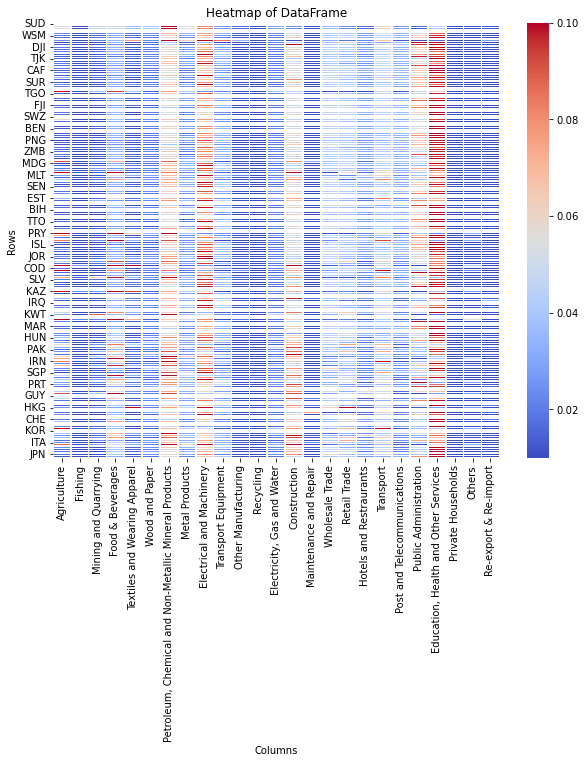

In [215]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(indirect_df.drop(columns=['Finacial Intermediation and Business Activities','final_demand']), vmin=0.01,vmax=0.1,annot=False, cmap="coolwarm", linewidths=0.5, cbar=True)

# Customize labels
plt.title("Heatmap of DataFrame")
plt.xlabel("Columns")
plt.ylabel("Rows")

# Show the plot
plt.show()


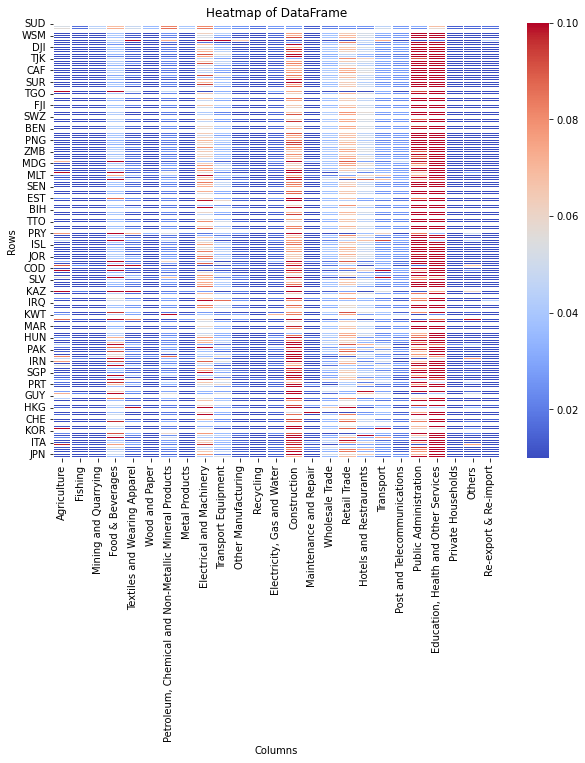

In [216]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(direct_df.drop(columns=['Finacial Intermediation and Business Activities','final_demand']), vmin=0.01,vmax=0.1,annot=False, cmap="coolwarm", linewidths=0.5, cbar=True)

# Customize labels
plt.title("Heatmap of DataFrame")
plt.xlabel("Columns")
plt.ylabel("Rows")

# Show the plot
plt.show()
